In [1]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# AutoML optuna library
import optuna
import optuna.integration.lightgbm as lgb

# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metric
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## for PCA
from sklearn.decomposition import PCA

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# data load
df = pd.read_csv('original_full_data_2.csv')
mmdf = pd.read_csv('bloomberg_map_index_20200318.csv', index_col = 0)

In [3]:
# From the date the target data is present ~
df = df.loc[9132 :, :]

In [4]:
df.reset_index(inplace = True, drop = True)

In [5]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = ((self.df[target_column] / self.df[target_column].shift(periods = self.target_day, axis = 0))-1).shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [6]:
newdf = df.copy()

In [7]:
len(newdf.columns)

417

In [8]:
# date preprocessing

newdf['date'] = pd.to_datetime(newdf['date'])
newdf.set_index('date', inplace = True)

In [9]:
# fillna cubic -> ffill -> bfill

newdf = newdf.interpolate(method = 'cubic', limit_area = 'inside')
newdf = newdf.fillna(method = 'ffill')
newdf = newdf.fillna(method = 'bfill')

In [10]:
# check na value

newdf.isna().sum().sum()

0

In [11]:
# class load

cla = Builder(newdf, mmdf, 120)

In [12]:
# execution function
# 새로운 데이터프레임 생성 
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOTIndex,GPDITOCIndex,GPGSTOCIndex,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,CPIYOYIndex,CPIXYOYIndex,PCEDEFYIndex,PCECYOYIndex,CPICHNGIndex,CPUPXCHGIndex,FDIDFDMOIndex,FDIDSGMOIndex,FDIUFDYOIndex,FDIUSGYOIndex,USURTOTIndex,USUDMAERIndex,INJCJCIndex,INJCSPIndex,NFPTCHIndex,...,AMD_product,APPLE_product,AppliedMaterials_product,Aspeed_product,Dell_product,Facebook_product,Google_product,HPE_product,Intel_product,LamResearch_product,MediaTek_product,Micron_product,Microsoft_product,Nuvoton_product,Nvidia_product,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.700000,8.400000,326.0,2561.0,278.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.700000,8.400000,326.0,2561.0,278.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.700000,8.400000,326.0,2561.0,278.000000,...,0.682030,0.771197,1.026287,1.000000,1.000000,1.000000,1.223552,1.000000,0.829714,0.967572,1.000000,1.380558,0.743634,1.000000,1.109161,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.700000,8.400000,326.0,2561.0,278.000000,...,1.264163,0.718678,1.094089,1.000000,1.000000,1.000000,0.710449,1.000000,1.204864,0.824310,1.000000,0.901202,0.836536,1.000000,1.294707,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,4.0,2.1,3.2,2.06622,0.6,0.2,0.1,0.3,2.6,2.2,4.700000,8.400000,326.0,2561.0,278.000000,...,0.966656,1.606885,1.514631,1.000000,1.000000,1.000000,1.685084,1.000000,0.833842,1.282477,1.000000,0.947752,2.059981,1.000000,0.980556,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,1.7,2.4,1.3,1.66611,0.0,0.1,-0.3,-0.3,1.4,2.0,3.543428,6.908116,218.0,1690.0,128.639710,...,0.900501,1.010875,1.764097,0.820641,0.808665,1.410060,1.415943,0.954658,0.776571,2.092578,0.829932,1.022473,1.347411,1.486079,0.898487,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,1.7,2.4,1.3,1.66611,0.0,0.1,-0.3,-0.3,1.4,2.0,3.556001,6.928135,218.0,1690.0,128.219228,...,1.213115,1.395378,1.417193,0.968297,1.516745,1.109701,1.114263,1.105058,0.581300,1.697246,3.008876,0.982582,1.005550,0.918295,0.709275,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,1.7,2.4,1.3,1.66611,0.0,0.1,-0.3,-0.3,1.4,2.0,3.569604,6.950086,218.0,1690.0,127.968071,...,1.506408,1.445075,0.717119,1.250066,1.680148,1.011607,0.793725,1.167880,0.557896,0.832619,1.914615,0.789692,0.580119,0.417745,0.626504,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [13]:
newdf['KRXsemiconductor_close']

date
2006-01-02    0.027330
2006-01-03    0.012002
2006-01-04    0.011368
2006-01-05    0.016794
2006-01-06   -0.009903
                ...   
2019-10-27         NaN
2019-10-28         NaN
2019-10-29         NaN
2019-10-30         NaN
2019-10-31         NaN
Name: KRXsemiconductor_close, Length: 5051, dtype: float64

In [14]:
# fill na for shifted data

newdf = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [15]:
# check na

newdf.isna().sum().sum()

0

In [16]:
# features

len(newdf.columns)

1138

In [17]:
len(newdf.columns)

1138

# Scaling

In [18]:
newdf.reset_index(inplace = True)

In [19]:
len(newdf)

5051

In [20]:
newdf = newdf[0:4931]

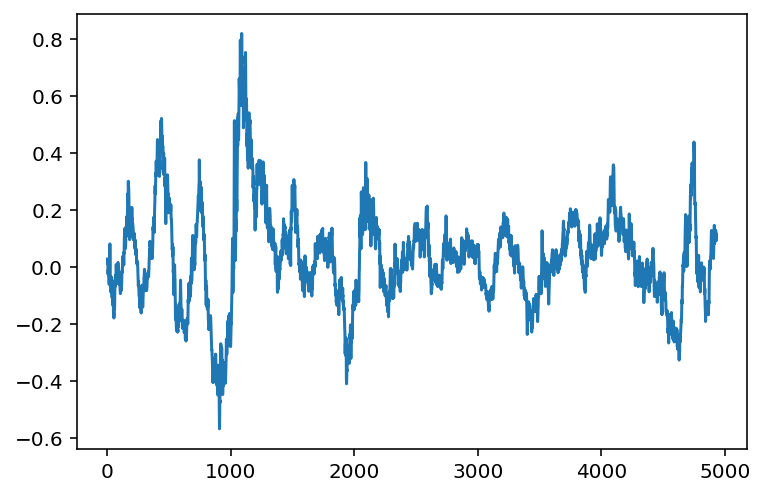

In [21]:
newdf['KRXsemiconductor_close'].plot()

In [22]:
newdf.to_csv('val_120.csv')

In [22]:
date = newdf.date

In [23]:
newdf.drop('date', axis = True, inplace = True)

In [24]:
# extract target
y_target = newdf['KRXsemiconductor_close']

In [25]:
# 1일 이 지점에서 각자 잡은 feature를 넣어주자
#newdf = newdf[['KRXsemiconductor_change', 'SKhynix_change', 'Philadelphia_change', 'Micron_change', 'MediaTek_change', 'USDollarIndex_close', 'FRNTTNETIndex', 'Intel_product', 'USD_KRW_change', 'CPUPXCHGIndex', 'KOBONTLIndex', 'RSTAMOMIndex', 'KOEXPTIYIndex', 'KOCPIMOMIndex', 'Dell_close', 'Dell_volume', 'GPGSTOC%Index', 'SKLIOTARIndex', 'Nvidia_volume', 'SKCIMOMIndex', 'KOCGCGYIndex', 'KOECPRCYIndex', 'LEIBPIndex', 'AMD_change', 'JOLTSEPSIndex', 'HPE_close', 'Sumco_change', 'KOGFBALIndex', 'CNFREXPYIndex', 'TokyoElectron_close', 'EUR_KRW_close', 'KOBPFINIndex', 'Amazon_change', 'UMC_product', 'KOECGVTYIndex', 'KOBPCAIndex', 'KOECIMPYIndex', 'NAPMNMIIndex', 'USWHTOTIndex', 'Amazon_volume', 'KOECFCSYIndex', 'Google_product', 'KOFDITYIndex', 'KOQEEYOYIndex', 'TokyoElectron_volume', 'CNGDPYOYIndex', 'MBRXYOYWIndex', 'ShinEtsuChemical_volume', 'USTBEXPYIndex', 'AppliedMaterials_product', 'QCOM_product', 'SKhynix_product', 'UMC_volume', 'APPLE_product', 'KOECSIMQIndex', 'SKLICPYIndex', 'SKLICONEIndex', 'LEIMNOIndex', 'SAARDTOTIndex', 'KOBPCBIndex', 'USHEYOYIndex', 'USEMNCHGIndex', 'MGT2MAIndex', 'KOPPIMOMIndex', 'KOIVCONYIndex', 'Intel_volume', 'g16', 'AMD_product', 'KOEXTOTIndex', 'KOFETOTIndex', 'SKLINBARIndex', 'ssd_price', 'SKLILAPIndex', 'KOCPIIndex', 'TSMC_product', 'KOPPIYOYIndex', 'Philadelphia_volume', 'APPLE_volume', 'RSTAYOYIndex', 'Micron_product', 'Micron_volume', 'PITLCHNGIndex', 'SAARTOTLIndex', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'TokyoElectron_change', 'Intel_change', 'KOWDRIndex', 'Nvidia_product', 'ShinEtsuChemical_close', 'memory_price', 'NFPTCHIndex', 'NFPPCHIndex', 'KOGDPYOYIndex', 'KOEAEPRIndex', 'USGG3MIndex', 'SKLILAIIndex']]

In [26]:
# 전 변수 쓰는 것으로 . 그래서 feaature는 그대로 
#['OEKRKLARIndex1', 'SKLIWNRSIndex260', 'MediaTek_close', 'TokyoElectron_close', 'SKLIEMPPIndex260', 'KOBONTLIndex260', 'SKLISVCIIndex60', 'KOUETTYIndex', 'KOQEEYOYIndex', 'FRNTTOTLIndex', 'KOFETOTIndex1', 'CONSSENTIndex60', 'GDPCPCECIndex', 'SKLIIMPTIndex1', 'LEIAVGWIndex120', 'KOBPCBIndex20', 'pbr', 'KOWDRIndex1', 'PCEDEFYIndex', 'CPMINEXOIndex20', 'NAPMNMIIndex20', 'NAPMNMIIndex1', 'EMPRGBCIIndex120', 'KOSPI200_change', 'SKLICONTIndex20', 'CPMINDXIndex20', 'CHALYOY%Index', 'KOEXTOTIndex260', 'KOWDRIndex60', 'SKLISVCIIndex120', 'SKLILCIndex1', 'KOBPCBIndex5', 'CICRTOTIndex1', 'USEMNCHGIndex', 'Nuvoton_change', 'KOBPCBIndex1', 'USTBEXPIndex260', 'EMPRGBCIIndex20', 'CHPMINDXIndex20', 'JOLTSEPSIndex', 'CNCILIIndex20', 'CNCILIIndex1', 'CNCILIIndex5', 'OUTFGAFIndex1', 'AWHTOTLIndex1', 'KOIPMYIndex', 'Intel_change', 'Amazon_product', 'PIDSPINXIndex60', 'AppliedMaterials_product', 'APPLE_change', 'ISECloudComputingIndex_change', 'ShinEtsuChemical_volume', 'QCOM_change', 'INJCJCIndex5', 'KOCGCGYIndex', 'Amazon_change', 'SKLINEIndex1', 'LEIACEIndex120', 'SKhynix_change', 'UMC_change', 'HPE_product', 'Google_change', 'TokyoElectron_product', 'CFNAIIndex5', 'CFNAIIndex20']


In [32]:
# 120일
newdf = newdf[['KRXsemiconductor_close', 'OEKRKLARIndex20', 'KOECSGVQIndex', 'SKLINEIndex260', 'MediaTek_close', 'KOHEUINYIndex', 'KOIPMSIndex60', 'SKLILAPIndex20', 'KOGFBALIndex260', 'LEISTKPIndex5', 'KOTRBALIndex260', 'KOGFTEXPIndex260', 'AWHTOTLIndex60', 'KOULMGFIndex', 'KODSDEPTIndex', 'OUTFGAFIndex1', 'CONSSENTIndex20', 'KOVMDOMSIndex1', 'KRXsemiconductor_change', 'SKLILAIIndex120', 'CONSSENTIndex260', 'USTBTOTIndex20', 'KOIVCONYIndex', 'SKLICONTIndex20', 'KOIMPTIIndex20', 'LEINWCNIndex5', 'KOBSMCIndex260', 'SKhynix_change', 'FRNTTNETIndex5', 'KOQEEYOYIndex', 'Intel_change', 'DGNOCHNGIndex', 'CICRTOTIndex1', 'KOELTOTIndex1', 'CNCILIIndex60', 'USTBIMPIndex5', 'KOGFBALIndex60', 'Micron_change', 'KOBSNMCIndex20', 'KOVMEXPSIndex1', 'KOVMPRODIndex20', 'SKBSICSAIndex20', 'KOVMPRODIndex1', 'SKCITTLIndex120', 'INJCSPIndex5', 'KORSTYIndex', 'KOCGCGYIndex', 'NAPMPMIIndex60', 'KOIVCCYIndex', 'KOBPCAIndex5', 'KOBPCAIndex1', 'AWHTOTLIndex5', 'Aspeed_change', 'SKLISHPPIndex20', 'KOGFBALIndex120', 'CICRTOTIndex260', 'USD_KRW_change', 'Microsoft_change', 'KODIBALIndex120', 'LEIMNOIndex5', 'ShinEtsuChemical_volume', 'RSTAMOMIndex', 'KOVMTOTSIndex1', 'IPIndex5', 'KOEXTOTIndex1', 'COMFCOMFIndex1', 'INJCSPIndex1', 'LEIBPIndex120', 'TokyoElectron_product']
]

In [33]:
a, b = dmatrices('KRXsemiconductor_close ~ OEKRKLARIndex20+ KOECSGVQIndex+ SKLINEIndex260+ MediaTek_close+ KOHEUINYIndex+ KOIPMSIndex60+ SKLILAPIndex20+ KOGFBALIndex260+ LEISTKPIndex5+ KOTRBALIndex260+ KOGFTEXPIndex260+ AWHTOTLIndex60+ KOULMGFIndex+ KODSDEPTIndex+ OUTFGAFIndex1+ CONSSENTIndex20+ KOVMDOMSIndex1+ KRXsemiconductor_change+ SKLILAIIndex120+ CONSSENTIndex260+ USTBTOTIndex20+ KOIVCONYIndex+ SKLICONTIndex20+ KOIMPTIIndex20+ LEINWCNIndex5+ KOBSMCIndex260+ SKhynix_change+ FRNTTNETIndex5+ KOQEEYOYIndex+ Intel_change+ DGNOCHNGIndex+ CICRTOTIndex1+ KOELTOTIndex1+ CNCILIIndex60+ USTBIMPIndex5+ KOGFBALIndex60+ Micron_change+ KOBSNMCIndex20+ KOVMEXPSIndex1+ KOVMPRODIndex20+ SKBSICSAIndex20+ KOVMPRODIndex1+ SKCITTLIndex120+ INJCSPIndex5+ KORSTYIndex+ KOCGCGYIndex+ NAPMPMIIndex60+ KOIVCCYIndex+ KOBPCAIndex5+ KOBPCAIndex1+ AWHTOTLIndex5+ Aspeed_change+ SKLISHPPIndex20+ KOGFBALIndex120+ CICRTOTIndex260+ USD_KRW_change+ Microsoft_change+ KODIBALIndex120+ LEIMNOIndex5+ ShinEtsuChemical_volume+ RSTAMOMIndex+ KOVMTOTSIndex1+ IPIndex5+ KOEXTOTIndex1+ COMFCOMFIndex1+ INJCSPIndex1+ LEIBPIndex120+ TokyoElectron_product', newdf, return_type = 'dataframe')


In [34]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns 
vif

,VIF Factor,features
0,271.046345,Intercept
1,6.102949,OEKRKLARIndex20
2,2.041378,KOECSGVQIndex
3,2.090801,SKLINEIndex260
4,2.591196,MediaTek_close
...,...,...
64,3.679731,KOEXTOTIndex1
65,1.086185,COMFCOMFIndex1
66,3.412906,INJCSPIndex1
67,2.556269,LEIBPIndex120


In [35]:
vif.drop(0, inplace = True)

In [36]:
vif.sort_values(by = 'VIF Factor', inplace = True)

In [37]:
vif_columns = vif[vif['VIF Factor']  <=  10].features

In [38]:
len(newdf.columns)

69

In [25]:
newdf.drop(['KRXsemiconductor_close'], axis = 1, inplace = True)

In [40]:
vif[vif['VIF Factor']  >=  10]

,VIF Factor,features
42,29.311563,KOVMPRODIndex1
49,35.878469,KOBPCAIndex5
50,36.015250,KOBPCAIndex1
17,98.420198,KOVMDOMSIndex1
39,542.101015,KOVMEXPSIndex1
62,920.567266,KOVMTOTSIndex1


In [41]:
newdf = newdf[list(vif_columns)]

In [42]:
newdf.columns

Index(['TokyoElectron_product', 'Aspeed_change', 'ShinEtsuChemical_volume', 'COMFCOMFIndex1',
       'USD_KRW_change', 'FRNTTNETIndex5', 'DGNOCHNGIndex', 'Micron_change', 'OUTFGAFIndex1',
       'AWHTOTLIndex5', 'CICRTOTIndex1', 'CONSSENTIndex20', 'LEIMNOIndex5', 'Microsoft_change',
       'KODIBALIndex120', 'LEINWCNIndex5', 'SKBSICSAIndex20', 'AWHTOTLIndex60', 'KOIVCCYIndex',
       'KOBSNMCIndex20', 'SKLICONTIndex20', 'Intel_change', 'CICRTOTIndex260', 'LEISTKPIndex5',
       'KOECSGVQIndex', 'KOIMPTIIndex20', 'KOIVCONYIndex', 'SKLINEIndex260', 'SKhynix_change',
       'SKLILAPIndex20', 'SKLILAIIndex120', 'KOTRBALIndex260', 'CNCILIIndex60',
       'KRXsemiconductor_change', 'KOQEEYOYIndex', 'LEIBPIndex120', 'MediaTek_close',
       'KOGFBALIndex260', 'IPIndex5', 'KOELTOTIndex1', 'KOGFBALIndex60', 'RSTAMOMIndex',
       'SKCITTLIndex120', 'NAPMPMIIndex60', 'KOGFTEXPIndex260', 'KODSDEPTIndex',
       'CONSSENTIndex260', 'SKLISHPPIndex20', 'KOHEUINYIndex', 'USTBTOTIndex20', 'INJCSPIndex

In [43]:
len(newdf.columns)

62

In [44]:
# scaling 하기전에 columns 뽑기 
col_name = newdf.columns

In [45]:
newdf.drop(['SamsungElectronics_product'], axis = 1, inplace = True)

KeyError: "['SamsungElectronics_product'] not found in axis"

In [46]:
# scaling과 동시에 변환
#newdf = PowerTransformer().fit_transform(newdf)
newdf = StandardScaler().fit_transform(newdf)
#newdf = newdf.apply(lambda x : np.log1p(x))
#newdf = MinMaxScaler().fit_transfrom(newdf)

In [47]:
# scaling하면 colname사라지므로 다시 생성
newdf = pd.DataFrame(newdf, columns = col_name)

In [48]:
len(newdf.columns)

62

In [49]:
newdf.isna().sum().sum()

0

In [50]:
# extract X_data
X_data = newdf.copy()

### 이 단계에서 PCA를 적용해봐

In [33]:
#pca = PCA(n_components = 20)

In [34]:
#pca.fit(X_data)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
#X_pca = pca.transform(X_data)

In [36]:
# shape check
#X_pca.shape

(5051, 20)

In [52]:
# random split과 not random split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [37]:
# 이건 PCA를 위한 Data split
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y_target, test_size = 0.2, shuffle = False)

# Linear Feature Selection
## 안돌려도 무방

# Metric Class

In [53]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

# Linear Model

In [54]:
# linear model select
lr_reg = LinearRegression()
#lasso = Lasso(alpha = 100)

In [55]:
lr_reg.fit(X_train, y_train)
y_pred = lr_reg.predict(X_test)

In [56]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.96898,0.9389,0.0282,0.0362,0.917933,0.997976


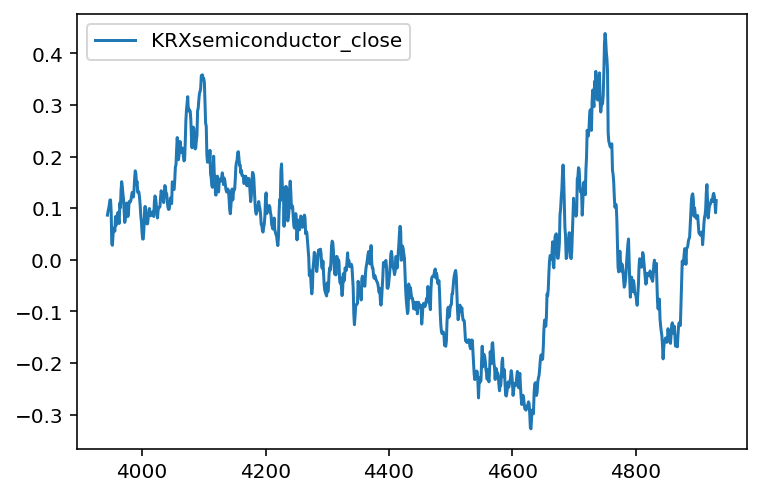

In [57]:
pd.DataFrame(y_test).plot()

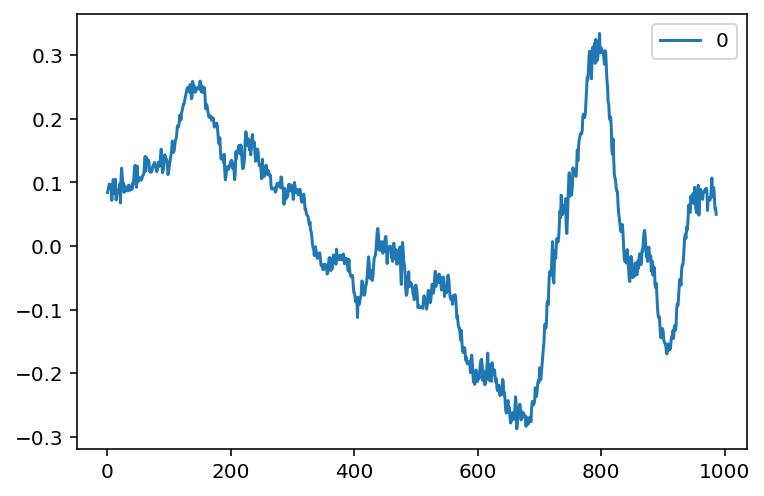

In [58]:
pd.DataFrame(y_pred).plot()

# Feature Importance Visualization

Linear Model은 회귀계수로 나오므로 아래와 같이 시각화

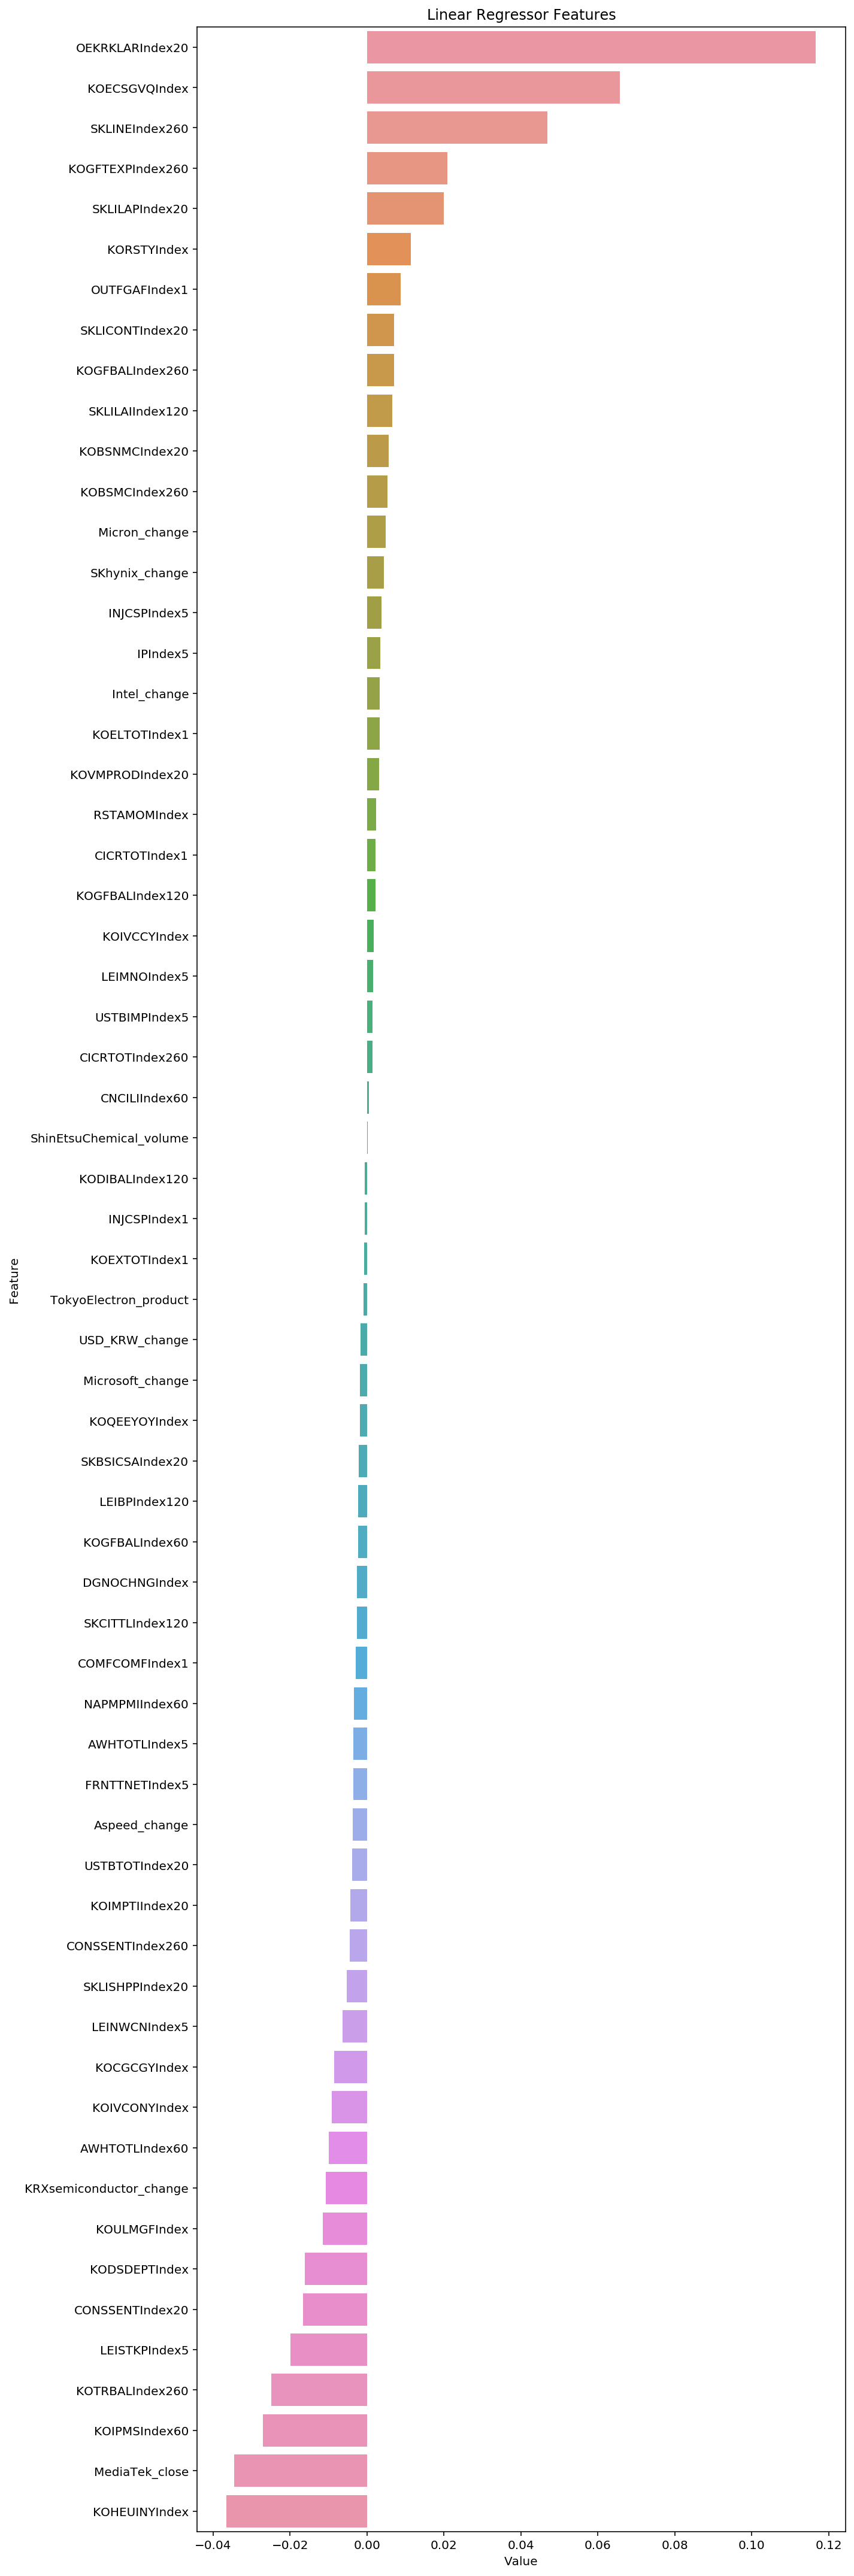

In [60]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

Tree Model은 feature importance가 따로 뽑히므로 아래와 같이 시각화

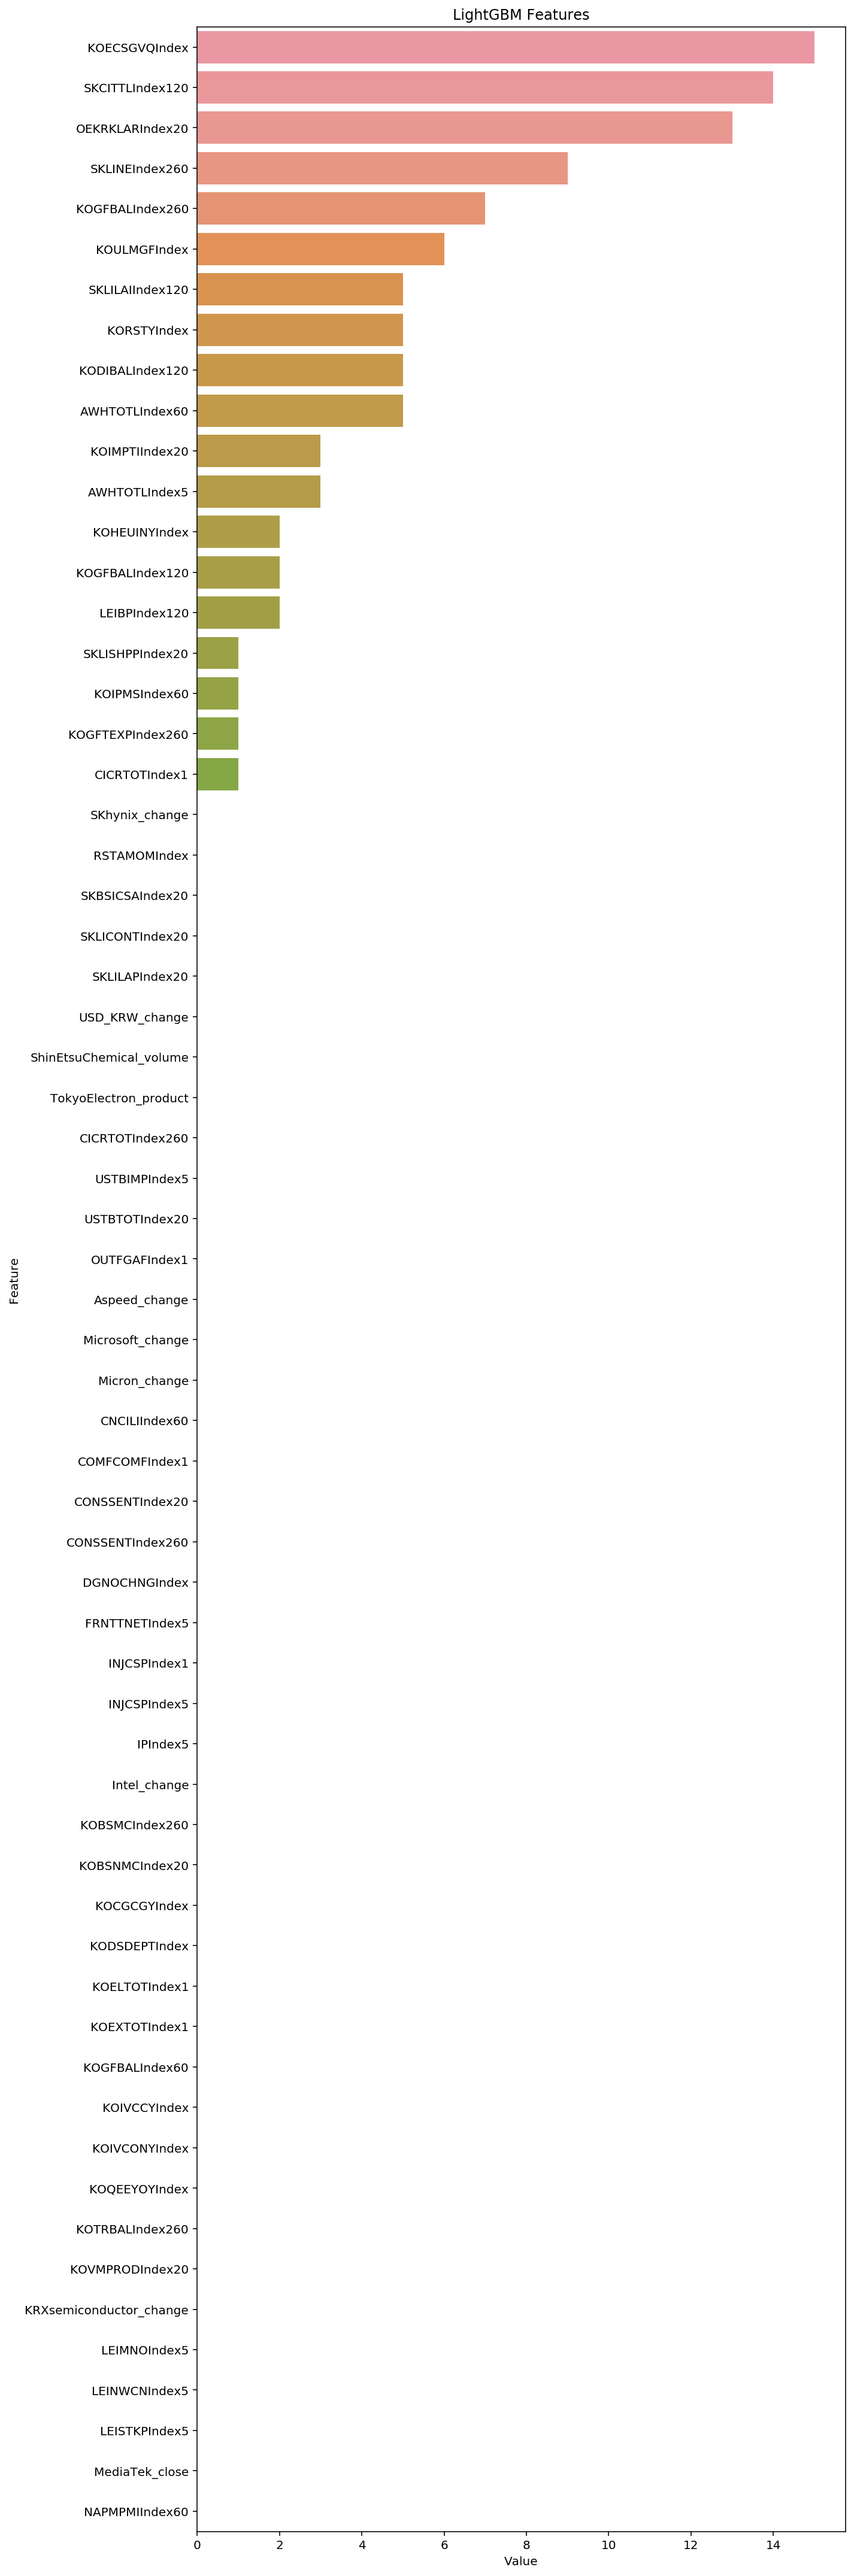

In [71]:
feat_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
feat_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = feat_imp.sort_values(by = 'Value', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_1.png')
plt.show()

# Optuna AutoML을 통한 LightGBM Hyperparameter tuning

In [61]:
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import r2_score
import optuna
import optuna.integration.lightgbm as lgb

In [62]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

best_params, tuning_history = dict(), list()

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dval],
                  best_params=best_params,
                  tuning_history=tuning_history,
                  verbose_eval=100,
                  early_stopping_rounds=100,
                  )

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
r2_score = r2_score(y_test, prediction)

print('Number of finished trials: {}'.format(len(tuning_history)))
print('Best params:', best_params)
print('  r2_score = {}'.format(r2_score))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000193101	valid_1's l2: 0.0188603
Early stopping, best iteration is:
[99]	training's l2: 0.000195538	valid_1's l2: 0.0188174


tune_feature_fraction, val_score: 0.018817:  14%|#4        | 1/7 [00:00<00:01,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000190871	valid_1's l2: 0.0193925
[200]	training's l2: 6.44443e-05	valid_1's l2: 0.0193839
Early stopping, best iteration is:
[152]	training's l2: 0.000102035	valid_1's l2: 0.0193367


tune_feature_fraction, val_score: 0.018817:  29%|##8       | 2/7 [00:00<00:01,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000182247	valid_1's l2: 0.0186725
[200]	training's l2: 6.11597e-05	valid_1's l2: 0.0185689
[300]	training's l2: 2.57766e-05	valid_1's l2: 0.0185878
Early stopping, best iteration is:
[200]	training's l2: 6.11597e-05	valid_1's l2: 0.0185689


tune_feature_fraction, val_score: 0.018569:  43%|####2     | 3/7 [00:01<00:01,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00017989	valid_1's l2: 0.0186672
[200]	training's l2: 5.86927e-05	valid_1's l2: 0.0185651
[300]	training's l2: 2.42111e-05	valid_1's l2: 0.0185551
Early stopping, best iteration is:
[277]	training's l2: 2.90377e-05	valid_1's l2: 0.0185416


tune_feature_fraction, val_score: 0.018542:  57%|#####7    | 4/7 [00:01<00:01,  2.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000169919	valid_1's l2: 0.0176235
[200]	training's l2: 5.59776e-05	valid_1's l2: 0.0174526
[300]	training's l2: 2.28174e-05	valid_1's l2: 0.0174092
[400]	training's l2: 1.05909e-05	valid_1's l2: 0.0173981
[500]	training's l2: 5.16656e-06	valid_1's l2: 0.0173651
[600]	training's l2: 2.6529e-06	valid_1's l2: 0.0173517
Early stopping, best iteration is:
[594]	training's l2: 2.76289e-06	valid_1's l2: 0.0173497


tune_feature_fraction, val_score: 0.017350:  71%|#######1  | 5/7 [00:02<00:01,  1.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000172248	valid_1's l2: 0.0178776
[200]	training's l2: 5.5883e-05	valid_1's l2: 0.0178322
Early stopping, best iteration is:
[122]	training's l2: 0.000129449	valid_1's l2: 0.0178164


tune_feature_fraction, val_score: 0.017350:  86%|########5 | 6/7 [00:03<00:00,  1.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000175835	valid_1's l2: 0.0227913
Early stopping, best iteration is:
[1]	training's l2: 0.0255855	valid_1's l2: 0.0222473


tune_num_leaves, val_score: 0.017350:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.70236e-05	valid_1's l2: 0.0193673
Early stopping, best iteration is:
[14]	training's l2: 0.00206514	valid_1's l2: 0.0185858


tune_num_leaves, val_score: 0.017350:   5%|5         | 1/20 [00:00<00:16,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.70236e-05	valid_1's l2: 0.0193673
Early stopping, best iteration is:
[14]	training's l2: 0.00206514	valid_1's l2: 0.0185858


tune_num_leaves, val_score: 0.017350:  10%|#         | 2/20 [00:01<00:14,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.70236e-05	valid_1's l2: 0.0193673
Early stopping, best iteration is:
[14]	training's l2: 0.00206514	valid_1's l2: 0.0185858


tune_num_leaves, val_score: 0.017350:  15%|#5        | 3/20 [00:02<00:13,  1.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000354421	valid_1's l2: 0.0179976
[200]	training's l2: 0.000153563	valid_1's l2: 0.0178362
Early stopping, best iteration is:
[117]	training's l2: 0.000300505	valid_1's l2: 0.0177892


tune_num_leaves, val_score: 0.017350:  20%|##        | 4/20 [00:02<00:10,  1.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00514363	valid_1's l2: 0.016366
[200]	training's l2: 0.00272676	valid_1's l2: 0.0152551
[300]	training's l2: 0.00179965	valid_1's l2: 0.0145324
[400]	training's l2: 0.00132358	valid_1's l2: 0.0136347
[500]	training's l2: 0.0010563	valid_1's l2: 0.0134276
[600]	training's l2: 0.00087613	valid_1's l2: 0.0133134
[700]	training's l2: 0.000752744	valid_1's l2: 0.0132913
Early stopping, best iteration is:
[677]	training's l2: 0.000780031	valid_1's l2: 0.0132018


tune_num_leaves, val_score: 0.013202:  25%|##5       | 5/20 [00:02<00:07,  1.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.06286e-05	valid_1's l2: 0.0185425
[200]	training's l2: 1.94369e-05	valid_1's l2: 0.0185017
[300]	training's l2: 6.2398e-06	valid_1's l2: 0.0184906
[400]	training's l2: 2.34272e-06	valid_1's l2: 0.0184856
Early stopping, best iteration is:
[367]	training's l2: 3.16802e-06	valid_1's l2: 0.0184823


tune_num_leaves, val_score: 0.013202:  30%|###       | 6/20 [00:04<00:10,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.44117e-05	valid_1's l2: 0.0179462
Early stopping, best iteration is:
[14]	training's l2: 0.00218312	valid_1's l2: 0.0176118


tune_num_leaves, val_score: 0.013202:  35%|###5      | 7/20 [00:04<00:08,  1.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.70236e-05	valid_1's l2: 0.0193673
Early stopping, best iteration is:
[14]	training's l2: 0.00206514	valid_1's l2: 0.0185858


tune_num_leaves, val_score: 0.013202:  40%|####      | 8/20 [00:05<00:08,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.0749e-05	valid_1's l2: 0.0183114
Early stopping, best iteration is:
[76]	training's l2: 0.00010049	valid_1's l2: 0.0182939


tune_num_leaves, val_score: 0.013202:  45%|####5     | 9/20 [00:05<00:07,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.70236e-05	valid_1's l2: 0.0193673
Early stopping, best iteration is:
[14]	training's l2: 0.00206514	valid_1's l2: 0.0185858


tune_num_leaves, val_score: 0.013202:  50%|#####     | 10/20 [00:06<00:06,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0032097	valid_1's l2: 0.016549
[200]	training's l2: 0.00153543	valid_1's l2: 0.0160935
[300]	training's l2: 0.000988957	valid_1's l2: 0.0151496
[400]	training's l2: 0.000731356	valid_1's l2: 0.0147941
[500]	training's l2: 0.000587635	valid_1's l2: 0.0146316
[600]	training's l2: 0.000492482	valid_1's l2: 0.0144975
[700]	training's l2: 0.000418815	valid_1's l2: 0.0144286
Early stopping, best iteration is:
[673]	training's l2: 0.000436156	valid_1's l2: 0.0143581


tune_num_leaves, val_score: 0.013202:  55%|#####5    | 11/20 [00:06<00:05,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00150632	valid_1's l2: 0.0156174
[200]	training's l2: 0.000719535	valid_1's l2: 0.0151355
[300]	training's l2: 0.000477188	valid_1's l2: 0.014844
[400]	training's l2: 0.000356293	valid_1's l2: 0.0147499
Early stopping, best iteration is:
[335]	training's l2: 0.000428836	valid_1's l2: 0.0146961


tune_num_leaves, val_score: 0.013202:  60%|######    | 12/20 [00:07<00:03,  2.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000827325	valid_1's l2: 0.0152831
[200]	training's l2: 0.000422066	valid_1's l2: 0.0147315
[300]	training's l2: 0.000273351	valid_1's l2: 0.0146713
Early stopping, best iteration is:
[208]	training's l2: 0.000405738	valid_1's l2: 0.0146515


tune_num_leaves, val_score: 0.013202:  65%|######5   | 13/20 [00:07<00:02,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.80293e-05	valid_1's l2: 0.0196256
Early stopping, best iteration is:
[6]	training's l2: 0.00927405	valid_1's l2: 0.0186937


tune_num_leaves, val_score: 0.013202:  70%|#######   | 14/20 [00:08<00:02,  2.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000126052	valid_1's l2: 0.0182116
[200]	training's l2: 3.74026e-05	valid_1's l2: 0.0181537
[300]	training's l2: 1.42417e-05	valid_1's l2: 0.0181329
[400]	training's l2: 6.00724e-06	valid_1's l2: 0.018144
Early stopping, best iteration is:
[312]	training's l2: 1.27279e-05	valid_1's l2: 0.0181279


tune_num_leaves, val_score: 0.013202:  75%|#######5  | 15/20 [00:08<00:02,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.09661e-05	valid_1's l2: 0.0186455
Early stopping, best iteration is:
[14]	training's l2: 0.0021574	valid_1's l2: 0.0182843


tune_num_leaves, val_score: 0.013202:  80%|########  | 16/20 [00:09<00:02,  1.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0094094	valid_1's l2: 0.0173477
[200]	training's l2: 0.00688881	valid_1's l2: 0.016405
[300]	training's l2: 0.00548468	valid_1's l2: 0.0145368
[400]	training's l2: 0.00454978	valid_1's l2: 0.0138499
[500]	training's l2: 0.00388	valid_1's l2: 0.0133178
[600]	training's l2: 0.00338058	valid_1's l2: 0.0130267
Early stopping, best iteration is:
[562]	training's l2: 0.00355402	valid_1's l2: 0.0128912


tune_num_leaves, val_score: 0.012891:  85%|########5 | 17/20 [00:09<00:01,  2.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 4.56682e-05	valid_1's l2: 0.0184312
Early stopping, best iteration is:
[14]	training's l2: 0.00227879	valid_1's l2: 0.0183769


tune_num_leaves, val_score: 0.012891:  90%|######### | 18/20 [00:10<00:00,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000169919	valid_1's l2: 0.0176235
[200]	training's l2: 5.59776e-05	valid_1's l2: 0.0174526
[300]	training's l2: 2.28174e-05	valid_1's l2: 0.0174092
[400]	training's l2: 1.05909e-05	valid_1's l2: 0.0173981
[500]	training's l2: 5.16656e-06	valid_1's l2: 0.0173651
[600]	training's l2: 2.6529e-06	valid_1's l2: 0.0173517
Early stopping, best iteration is:
[594]	training's l2: 2.76289e-06	valid_1's l2: 0.0173497


tune_num_leaves, val_score: 0.012891:  95%|#########5| 19/20 [00:11<00:00,  1.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.72078e-05	valid_1's l2: 0.0197958
Early stopping, best iteration is:
[6]	training's l2: 0.00925124	valid_1's l2: 0.0187539


tune_num_leaves, val_score: 0.012891: 100%|##########| 20/20 [00:11<00:00,  1.70it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.012891:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00928082	valid_1's l2: 0.0168012
[200]	training's l2: 0.00668284	valid_1's l2: 0.0155328
[300]	training's l2: 0.00523259	valid_1's l2: 0.0140768
[400]	training's l2: 0.00427289	valid_1's l2: 0.0129222
[500]	training's l2: 0.00359687	valid_1's l2: 0.0126747
[600]	training's l2: 0.00309975	valid_1's l2: 0.0125748
[700]	training's l2: 0.00271814	valid_1's l2: 0.0122192
[800]	training's l2: 0.00242309	valid_1's l2: 0.0120886
[900]	training's l2: 0.00218896	valid_1's l2: 0.0118599
[1000]	training's l2: 0.00199924	valid_1's l2: 0.0118517
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00199924	valid_1's l2: 0.0118517


tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  10%|#         | 1/10 [00:00<00:01,  4.96it/s][I 2020-03-18 22:59:58,104] Finished trial#0 resulted in value: 0.01185170015075258. Current best value is 0.01185170015075258 with parameters: {'bagging_fraction': 0.7565761096103317, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  10%|#         | 1/10 [00:00<00:01,  4.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924349	valid_1's l2: 0.0173309
[200]	training's l2: 0.00662349	valid_1's l2: 0.0159088
[300]	training's l2: 0.0051629	valid_1's l2: 0.0140654
[400]	training's l2: 0.00420491	valid_1's l2: 0.0137976
[500]	training's l2: 0.00353563	valid_1's l2: 0.0130341
[600]	training's l2: 0.00303768	valid_1's l2: 0.0129299
[700]	training's l2: 0.00266241	valid_1's l2: 0.0125942
[800]	training's l2: 0.00236869	valid_1's l2: 0.0122459
[900]	training's l2: 0.00213993	valid_1's l2: 0.0121607
[1000]	training's l2: 0.0019533	valid_1's l2: 0.0120257
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.0019533	valid_1's l2: 0.0120257


tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  20%|##        | 2/10 [00:00<00:01,  4.81it/s][I 2020-03-18 22:59:58,328] Finished trial#1 resulted in value: 0.01202570265033318. Current best value is 0.01185170015075258 with parameters: {'bagging_fraction': 0.7565761096103317, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  20%|##        | 2/10 [00:00<00:01,  4.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00935404	valid_1's l2: 0.0173958
[200]	training's l2: 0.00678014	valid_1's l2: 0.016102
[300]	training's l2: 0.00534044	valid_1's l2: 0.0145947
[400]	training's l2: 0.00438379	valid_1's l2: 0.0136339
[500]	training's l2: 0.00370343	valid_1's l2: 0.0130952
[600]	training's l2: 0.00320696	valid_1's l2: 0.0131688
Early stopping, best iteration is:
[524]	training's l2: 0.00356905	valid_1's l2: 0.0130099


tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  30%|###       | 3/10 [00:00<00:01,  5.03it/s][I 2020-03-18 22:59:58,506] Finished trial#2 resulted in value: 0.013009919200236447. Current best value is 0.01185170015075258 with parameters: {'bagging_fraction': 0.7565761096103317, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  30%|###       | 3/10 [00:00<00:01,  5.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00931935	valid_1's l2: 0.0166349
[200]	training's l2: 0.00676597	valid_1's l2: 0.0159129
[300]	training's l2: 0.00534175	valid_1's l2: 0.0141375
[400]	training's l2: 0.00440105	valid_1's l2: 0.0133203
[500]	training's l2: 0.0037258	valid_1's l2: 0.0129561
[600]	training's l2: 0.00322829	valid_1's l2: 0.0127258
[700]	training's l2: 0.00284495	valid_1's l2: 0.0126738
[800]	training's l2: 0.00254414	valid_1's l2: 0.0125845
Early stopping, best iteration is:
[774]	training's l2: 0.00261665	valid_1's l2: 0.0124553


tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  40%|####      | 4/10 [00:00<00:01,  5.01it/s][I 2020-03-18 22:59:58,707] Finished trial#3 resulted in value: 0.012455336889376023. Current best value is 0.01185170015075258 with parameters: {'bagging_fraction': 0.7565761096103317, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  40%|####      | 4/10 [00:00<00:01,  5.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00922918	valid_1's l2: 0.0167936
[200]	training's l2: 0.00659856	valid_1's l2: 0.0153331
[300]	training's l2: 0.00514079	valid_1's l2: 0.013624
[400]	training's l2: 0.00417517	valid_1's l2: 0.0129692
[500]	training's l2: 0.00349537	valid_1's l2: 0.0125347
[600]	training's l2: 0.00300551	valid_1's l2: 0.0121578
[700]	training's l2: 0.00262352	valid_1's l2: 0.0121003
[800]	training's l2: 0.00233518	valid_1's l2: 0.01196
Early stopping, best iteration is:
[723]	training's l2: 0.00255112	valid_1's l2: 0.0118641


tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  50%|#####     | 5/10 [00:00<00:00,  5.08it/s][I 2020-03-18 22:59:58,900] Finished trial#4 resulted in value: 0.011864093030237288. Current best value is 0.01185170015075258 with parameters: {'bagging_fraction': 0.7565761096103317, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011852:  50%|#####     | 5/10 [00:01<00:00,  5.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00923037	valid_1's l2: 0.0172461
[200]	training's l2: 0.00661255	valid_1's l2: 0.0162333
[300]	training's l2: 0.00516768	valid_1's l2: 0.014762
[400]	training's l2: 0.00419261	valid_1's l2: 0.0135935
[500]	training's l2: 0.00353136	valid_1's l2: 0.012726
[600]	training's l2: 0.00304107	valid_1's l2: 0.0125167
[700]	training's l2: 0.0026579	valid_1's l2: 0.0119996
[800]	training's l2: 0.00235873	valid_1's l2: 0.0119487
Early stopping, best iteration is:
[731]	training's l2: 0.00256493	valid_1's l2: 0.0117372


tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  60%|######    | 6/10 [00:01<00:00,  5.14it/s][I 2020-03-18 22:59:59,087] Finished trial#5 resulted in value: 0.011737201269889714. Current best value is 0.011737201269889714 with parameters: {'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  60%|######    | 6/10 [00:01<00:00,  5.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00910208	valid_1's l2: 0.0166049
[200]	training's l2: 0.00642675	valid_1's l2: 0.0150472
[300]	training's l2: 0.00498045	valid_1's l2: 0.0132121
Early stopping, best iteration is:
[288]	training's l2: 0.00512908	valid_1's l2: 0.0131593


tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  70%|#######   | 7/10 [00:01<00:00,  6.00it/s][I 2020-03-18 22:59:59,189] Finished trial#6 resulted in value: 0.013159274326827414. Current best value is 0.011737201269889714 with parameters: {'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  70%|#######   | 7/10 [00:01<00:00,  6.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00925894	valid_1's l2: 0.0169573
[200]	training's l2: 0.00664876	valid_1's l2: 0.0159852
[300]	training's l2: 0.00518794	valid_1's l2: 0.0142532
[400]	training's l2: 0.00422838	valid_1's l2: 0.01316
[500]	training's l2: 0.00354649	valid_1's l2: 0.0130053
[600]	training's l2: 0.00305565	valid_1's l2: 0.0126715
[700]	training's l2: 0.00267321	valid_1's l2: 0.0124499
[800]	training's l2: 0.00238112	valid_1's l2: 0.012206
[900]	training's l2: 0.00215296	valid_1's l2: 0.01195
Early stopping, best iteration is:
[885]	training's l2: 0.0021841	valid_1's l2: 0.011884


tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  80%|########  | 8/10 [00:01<00:00,  5.41it/s][I 2020-03-18 22:59:59,417] Finished trial#7 resulted in value: 0.011883966307668142. Current best value is 0.011737201269889714 with parameters: {'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  80%|########  | 8/10 [00:01<00:00,  5.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00931692	valid_1's l2: 0.016942
[200]	training's l2: 0.00677429	valid_1's l2: 0.0161111
[300]	training's l2: 0.00534094	valid_1's l2: 0.0140716
[400]	training's l2: 0.00440301	valid_1's l2: 0.0134208
[500]	training's l2: 0.00372839	valid_1's l2: 0.0127508
[600]	training's l2: 0.0032294	valid_1's l2: 0.0128853
Early stopping, best iteration is:
[557]	training's l2: 0.00342216	valid_1's l2: 0.0126726


tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  90%|######### | 9/10 [00:01<00:00,  5.33it/s][I 2020-03-18 22:59:59,611] Finished trial#8 resulted in value: 0.012672636210827839. Current best value is 0.011737201269889714 with parameters: {'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011737:  90%|######### | 9/10 [00:01<00:00,  5.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00925803	valid_1's l2: 0.0172748
[200]	training's l2: 0.00662186	valid_1's l2: 0.0158923
[300]	training's l2: 0.00517273	valid_1's l2: 0.0146675
[400]	training's l2: 0.00419245	valid_1's l2: 0.013886
[500]	training's l2: 0.00352705	valid_1's l2: 0.0133341
[600]	training's l2: 0.00303377	valid_1's l2: 0.012957
[700]	training's l2: 0.00264024	valid_1's l2: 0.0130164
Early stopping, best iteration is:
[647]	training's l2: 0.00283821	valid_1's l2: 0.0125717


tune_bagging_fraction_and_bagging_freq, val_score: 0.011737: 100%|##########| 10/10 [00:01<00:00,  5.11it/s][I 2020-03-18 22:59:59,827] Finished trial#9 resulted in value: 0.012571723308089578. Current best value is 0.011737201269889714 with parameters: {'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.011737: 100%|##########| 10/10 [00:01<00:00,  5.10it/s]
tune_feature_fraction, val_score: 0.011737:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924072	valid_1's l2: 0.0172396
[200]	training's l2: 0.0066291	valid_1's l2: 0.0158912
[300]	training's l2: 0.0051789	valid_1's l2: 0.0146569
[400]	training's l2: 0.00420507	valid_1's l2: 0.013599
[500]	training's l2: 0.00353148	valid_1's l2: 0.0127461
Early stopping, best iteration is:
[490]	training's l2: 0.00358823	valid_1's l2: 0.0125799


tune_feature_fraction, val_score: 0.011737:  17%|#6        | 1/6 [00:00<00:00,  7.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00925463	valid_1's l2: 0.0173102
[200]	training's l2: 0.0066052	valid_1's l2: 0.016286
[300]	training's l2: 0.00516841	valid_1's l2: 0.0146986
[400]	training's l2: 0.00420293	valid_1's l2: 0.0138095
[500]	training's l2: 0.0035359	valid_1's l2: 0.0130065
[600]	training's l2: 0.0030441	valid_1's l2: 0.0126747
[700]	training's l2: 0.00266059	valid_1's l2: 0.0121036
[800]	training's l2: 0.0023618	valid_1's l2: 0.011925
Early stopping, best iteration is:
[742]	training's l2: 0.00252994	valid_1's l2: 0.0118462


tune_feature_fraction, val_score: 0.011737:  33%|###3      | 2/6 [00:00<00:00,  6.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00923904	valid_1's l2: 0.0174225
[200]	training's l2: 0.00661768	valid_1's l2: 0.016485
[300]	training's l2: 0.00517704	valid_1's l2: 0.0146803
[400]	training's l2: 0.00421118	valid_1's l2: 0.0137008
[500]	training's l2: 0.00354709	valid_1's l2: 0.0128967
[600]	training's l2: 0.00305307	valid_1's l2: 0.0126335
[700]	training's l2: 0.00267377	valid_1's l2: 0.0121133
[800]	training's l2: 0.00236977	valid_1's l2: 0.0118881
[900]	training's l2: 0.00214346	valid_1's l2: 0.0118523
[1000]	training's l2: 0.00196123	valid_1's l2: 0.0117746
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00196123	valid_1's l2: 0.0117746


tune_feature_fraction, val_score: 0.011737:  50%|#####     | 3/6 [00:00<00:00,  5.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00923997	valid_1's l2: 0.0172845
[200]	training's l2: 0.00663548	valid_1's l2: 0.0163891
[300]	training's l2: 0.00518285	valid_1's l2: 0.0147402
[400]	training's l2: 0.00420911	valid_1's l2: 0.0136992
[500]	training's l2: 0.00353759	valid_1's l2: 0.0127436
[600]	training's l2: 0.00305031	valid_1's l2: 0.0125533
[700]	training's l2: 0.00267161	valid_1's l2: 0.0119445
[800]	training's l2: 0.00236529	valid_1's l2: 0.0118471
Early stopping, best iteration is:
[740]	training's l2: 0.00254514	valid_1's l2: 0.011621


tune_feature_fraction, val_score: 0.011621:  67%|######6   | 4/6 [00:00<00:00,  5.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00923755	valid_1's l2: 0.0172381
[200]	training's l2: 0.00662751	valid_1's l2: 0.0161836
[300]	training's l2: 0.00516572	valid_1's l2: 0.0142905
[400]	training's l2: 0.00419771	valid_1's l2: 0.013426
[500]	training's l2: 0.00352817	valid_1's l2: 0.0127595
Early stopping, best iteration is:
[490]	training's l2: 0.00358476	valid_1's l2: 0.0126454


tune_feature_fraction, val_score: 0.011621:  83%|########3 | 5/6 [00:00<00:00,  5.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924318	valid_1's l2: 0.0166315
[200]	training's l2: 0.00662536	valid_1's l2: 0.0155254
[300]	training's l2: 0.00518913	valid_1's l2: 0.0141282
[400]	training's l2: 0.00421668	valid_1's l2: 0.0133682
[500]	training's l2: 0.00354183	valid_1's l2: 0.0124839
[600]	training's l2: 0.0030479	valid_1's l2: 0.0123582
[700]	training's l2: 0.00266741	valid_1's l2: 0.0118031
[800]	training's l2: 0.00236364	valid_1's l2: 0.0116153
Early stopping, best iteration is:
[734]	training's l2: 0.00255994	valid_1's l2: 0.0115492


tune_feature_fraction, val_score: 0.011549: 100%|##########| 6/6 [00:01<00:00,  5.37it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.011549:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.009381	valid_1's l2: 0.0170529
[200]	training's l2: 0.00677201	valid_1's l2: 0.0160566
[300]	training's l2: 0.00531338	valid_1's l2: 0.014307
[400]	training's l2: 0.00432029	valid_1's l2: 0.0134938
[500]	training's l2: 0.0036379	valid_1's l2: 0.0127837
Early stopping, best iteration is:
[488]	training's l2: 0.00371059	valid_1's l2: 0.0126224


tune_lambda_l1_and_lambda_l2, val_score: 0.011549:   5%|5         | 1/20 [00:00<00:02,  9.12it/s][I 2020-03-18 23:00:01,098] Finished trial#0 resulted in value: 0.012622359233512431. Current best value is 0.012622359233512431 with parameters: {'lambda_l1': 0.0033878577236246318, 'lambda_l2': 4.867645902065015}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011549:   5%|5         | 1/20 [00:00<00:02,  9.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924318	valid_1's l2: 0.0166315
[200]	training's l2: 0.00662536	valid_1's l2: 0.0155254
[300]	training's l2: 0.00518913	valid_1's l2: 0.0141282
[400]	training's l2: 0.00421668	valid_1's l2: 0.0133682
[500]	training's l2: 0.00354183	valid_1's l2: 0.0124839
[600]	training's l2: 0.0030479	valid_1's l2: 0.0123582
[700]	training's l2: 0.00266742	valid_1's l2: 0.0118031
[800]	training's l2: 0.00236364	valid_1's l2: 0.0116153
Early stopping, best iteration is:
[734]	training's l2: 0.00255994	valid_1's l2: 0.0115492


tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  10%|#         | 2/20 [00:00<00:02,  7.48it/s][I 2020-03-18 23:00:01,287] Finished trial#1 resulted in value: 0.011549207176643865. Current best value is 0.011549207176643865 with parameters: {'lambda_l1': 1.1256085716882104e-06, 'lambda_l2': 8.684508081135015e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  10%|#         | 2/20 [00:00<00:02,  7.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924318	valid_1's l2: 0.0166315
[200]	training's l2: 0.00662536	valid_1's l2: 0.0155254
[300]	training's l2: 0.00518913	valid_1's l2: 0.0141282
[400]	training's l2: 0.00421668	valid_1's l2: 0.0133682
[500]	training's l2: 0.00354183	valid_1's l2: 0.0124839
[600]	training's l2: 0.0030479	valid_1's l2: 0.0123582
[700]	training's l2: 0.00266741	valid_1's l2: 0.0118031
[800]	training's l2: 0.00236364	valid_1's l2: 0.0116153
Early stopping, best iteration is:
[734]	training's l2: 0.00255994	valid_1's l2: 0.0115492


tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  15%|#5        | 3/20 [00:00<00:02,  6.62it/s][I 2020-03-18 23:00:01,477] Finished trial#2 resulted in value: 0.011549206987920904. Current best value is 0.011549206987920904 with parameters: {'lambda_l1': 2.27564037200753e-08, 'lambda_l2': 5.02994194971434e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  15%|#5        | 3/20 [00:00<00:02,  6.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00943132	valid_1's l2: 0.0171286
[200]	training's l2: 0.00680705	valid_1's l2: 0.0159885
[300]	training's l2: 0.0053437	valid_1's l2: 0.014156
[400]	training's l2: 0.00436345	valid_1's l2: 0.013343
[500]	training's l2: 0.00367286	valid_1's l2: 0.0124263
Early stopping, best iteration is:
[488]	training's l2: 0.00374749	valid_1's l2: 0.0122831


tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  20%|##        | 4/20 [00:00<00:02,  6.73it/s][I 2020-03-18 23:00:01,621] Finished trial#3 resulted in value: 0.012283136370598845. Current best value is 0.011549206987920904 with parameters: {'lambda_l1': 2.27564037200753e-08, 'lambda_l2': 5.02994194971434e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011549:  20%|##        | 4/20 [00:00<00:02,  6.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00948053	valid_1's l2: 0.0165521
[200]	training's l2: 0.0069402	valid_1's l2: 0.0153242
[300]	training's l2: 0.00553216	valid_1's l2: 0.0136324
[400]	training's l2: 0.00457352	valid_1's l2: 0.0130127
[500]	training's l2: 0.00389742	valid_1's l2: 0.0120847
[600]	training's l2: 0.00340509	valid_1's l2: 0.0118846
[700]	training's l2: 0.00301825	valid_1's l2: 0.0113394
[800]	training's l2: 0.0027162	valid_1's l2: 0.0112615
[900]	training's l2: 0.00249082	valid_1's l2: 0.0112652
Early stopping, best iteration is:
[830]	training's l2: 0.00264447	valid_1's l2: 0.0111206


tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  25%|##5       | 5/20 [00:00<00:02,  5.84it/s][I 2020-03-18 23:00:01,845] Finished trial#4 resulted in value: 0.011120589649861498. Current best value is 0.011120589649861498 with parameters: {'lambda_l1': 0.6675375868450271, 'lambda_l2': 0.5006273971210122}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  25%|##5       | 5/20 [00:00<00:02,  5.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0092613	valid_1's l2: 0.0166521
[200]	training's l2: 0.00663358	valid_1's l2: 0.0153059
[300]	training's l2: 0.00518874	valid_1's l2: 0.0140764
[400]	training's l2: 0.00421346	valid_1's l2: 0.0132672
[500]	training's l2: 0.00354219	valid_1's l2: 0.0124761
Early stopping, best iteration is:
[490]	training's l2: 0.00360171	valid_1's l2: 0.012412


tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  30%|###       | 6/20 [00:01<00:02,  6.09it/s][I 2020-03-18 23:00:01,993] Finished trial#5 resulted in value: 0.012411950739470162. Current best value is 0.011120589649861498 with parameters: {'lambda_l1': 0.6675375868450271, 'lambda_l2': 0.5006273971210122}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  30%|###       | 6/20 [00:01<00:02,  6.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924424	valid_1's l2: 0.0167486
[200]	training's l2: 0.0066269	valid_1's l2: 0.0153986
[300]	training's l2: 0.00518743	valid_1's l2: 0.0137706
[400]	training's l2: 0.0042091	valid_1's l2: 0.0129809
[500]	training's l2: 0.00354168	valid_1's l2: 0.0123026
[600]	training's l2: 0.00305342	valid_1's l2: 0.0120838
[700]	training's l2: 0.00267033	valid_1's l2: 0.0115352
[800]	training's l2: 0.00236665	valid_1's l2: 0.0113744
Early stopping, best iteration is:
[734]	training's l2: 0.0025648	valid_1's l2: 0.0112725


tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  35%|###5      | 7/20 [00:01<00:02,  5.65it/s][I 2020-03-18 23:00:02,200] Finished trial#6 resulted in value: 0.011272525992238361. Current best value is 0.011120589649861498 with parameters: {'lambda_l1': 0.6675375868450271, 'lambda_l2': 0.5006273971210122}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  35%|###5      | 7/20 [00:01<00:02,  5.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00928549	valid_1's l2: 0.0172181
[200]	training's l2: 0.00665599	valid_1's l2: 0.0157849
[300]	training's l2: 0.0052041	valid_1's l2: 0.014125
[400]	training's l2: 0.00423533	valid_1's l2: 0.0134301
[500]	training's l2: 0.003562	valid_1's l2: 0.012475
[600]	training's l2: 0.00307158	valid_1's l2: 0.0122114
[700]	training's l2: 0.00269777	valid_1's l2: 0.0117228
[800]	training's l2: 0.00239916	valid_1's l2: 0.0117208
Early stopping, best iteration is:
[729]	training's l2: 0.00261028	valid_1's l2: 0.01157


tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  40%|####      | 8/20 [00:01<00:02,  5.49it/s][I 2020-03-18 23:00:02,394] Finished trial#7 resulted in value: 0.011570041538994463. Current best value is 0.011120589649861498 with parameters: {'lambda_l1': 0.6675375868450271, 'lambda_l2': 0.5006273971210122}.
tune_lambda_l1_and_lambda_l2, val_score: 0.011121:  40%|####      | 8/20 [00:01<00:02,  5.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00969291	valid_1's l2: 0.0168301
[200]	training's l2: 0.00718023	valid_1's l2: 0.015663
[300]	training's l2: 0.00581642	valid_1's l2: 0.0138079
[400]	training's l2: 0.00487637	valid_1's l2: 0.0131132
[500]	training's l2: 0.00420927	valid_1's l2: 0.0119559
[600]	training's l2: 0.00371658	valid_1's l2: 0.0116358
[700]	training's l2: 0.0033271	valid_1's l2: 0.0112255
[800]	training's l2: 0.00301626	valid_1's l2: 0.0111331
[900]	training's l2: 0.00278249	valid_1's l2: 0.0111245
Early stopping, best iteration is:
[833]	training's l2: 0.00293451	valid_1's l2: 0.010998


tune_lambda_l1_and_lambda_l2, val_score: 0.010998:  45%|####5     | 9/20 [00:01<00:02,  5.27it/s][I 2020-03-18 23:00:02,602] Finished trial#8 resulted in value: 0.010998026723934289. Current best value is 0.010998026723934289 with parameters: {'lambda_l1': 1.1032833401415436, 'lambda_l2': 2.887017572189143}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010998:  45%|####5     | 9/20 [00:01<00:02,  5.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00943338	valid_1's l2: 0.0171209
[200]	training's l2: 0.00680557	valid_1's l2: 0.0155013
[300]	training's l2: 0.0053447	valid_1's l2: 0.0139557
[400]	training's l2: 0.00435664	valid_1's l2: 0.0134739
[500]	training's l2: 0.00366487	valid_1's l2: 0.0125439
Early stopping, best iteration is:
[490]	training's l2: 0.00372672	valid_1's l2: 0.0124591


tune_lambda_l1_and_lambda_l2, val_score: 0.010998:  50%|#####     | 10/20 [00:01<00:01,  5.58it/s][I 2020-03-18 23:00:02,757] Finished trial#9 resulted in value: 0.012459095983336917. Current best value is 0.010998026723934289 with parameters: {'lambda_l1': 1.1032833401415436, 'lambda_l2': 2.887017572189143}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010998:  50%|#####     | 10/20 [00:01<00:01,  5.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0100695	valid_1's l2: 0.016309
[200]	training's l2: 0.00768955	valid_1's l2: 0.015174
[300]	training's l2: 0.00641375	valid_1's l2: 0.0136996
[400]	training's l2: 0.00549479	valid_1's l2: 0.0130642
[500]	training's l2: 0.00489384	valid_1's l2: 0.011906
[600]	training's l2: 0.00441092	valid_1's l2: 0.0116676
[700]	training's l2: 0.00403927	valid_1's l2: 0.0111399
[800]	training's l2: 0.00373191	valid_1's l2: 0.010998
[900]	training's l2: 0.00351098	valid_1's l2: 0.0108783
Early stopping, best iteration is:
[893]	training's l2: 0.00352638	valid_1's l2: 0.0108438


tune_lambda_l1_and_lambda_l2, val_score: 0.010844:  55%|#####5    | 11/20 [00:01<00:01,  5.20it/s][I 2020-03-18 23:00:02,981] Finished trial#10 resulted in value: 0.010843800646745361. Current best value is 0.010843800646745361 with parameters: {'lambda_l1': 2.372022645767069, 'lambda_l2': 0.0011311899130299757}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010844:  55%|#####5    | 11/20 [00:02<00:01,  5.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0124086	valid_1's l2: 0.0161573
[200]	training's l2: 0.0107728	valid_1's l2: 0.014321
[300]	training's l2: 0.00990344	valid_1's l2: 0.0134811
[400]	training's l2: 0.00924825	valid_1's l2: 0.0130407
[500]	training's l2: 0.00890317	valid_1's l2: 0.0125917
[600]	training's l2: 0.00858508	valid_1's l2: 0.0121687
[700]	training's l2: 0.00835653	valid_1's l2: 0.0117132
[800]	training's l2: 0.00812018	valid_1's l2: 0.0113961
[900]	training's l2: 0.00794685	valid_1's l2: 0.0112312
[1000]	training's l2: 0.00782083	valid_1's l2: 0.0110936
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00782083	valid_1's l2: 0.0110936


tune_lambda_l1_and_lambda_l2, val_score: 0.010844:  60%|######    | 12/20 [00:02<00:01,  4.90it/s][I 2020-03-18 23:00:03,210] Finished trial#11 resulted in value: 0.01109364315264521. Current best value is 0.010843800646745361 with parameters: {'lambda_l1': 2.372022645767069, 'lambda_l2': 0.0011311899130299757}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010844:  60%|######    | 12/20 [00:02<00:01,  4.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0115954	valid_1's l2: 0.0157364
[200]	training's l2: 0.00969275	valid_1's l2: 0.0140964
[300]	training's l2: 0.00865251	valid_1's l2: 0.0129921
[400]	training's l2: 0.00789556	valid_1's l2: 0.0122775
[500]	training's l2: 0.00744212	valid_1's l2: 0.0114555
[600]	training's l2: 0.00705768	valid_1's l2: 0.011012
[700]	training's l2: 0.00676873	valid_1's l2: 0.0106358
[800]	training's l2: 0.00650562	valid_1's l2: 0.0102659
[900]	training's l2: 0.00629957	valid_1's l2: 0.0101036
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  65%|######5   | 13/20 [00:02<00:01,  4.69it/s][I 2020-03-18 23:00:03,445] Finished trial#12 resulted in value: 0.010067774093782435. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  65%|######5   | 13/20 [00:02<00:01,  4.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00976104	valid_1's l2: 0.0164342
[200]	training's l2: 0.00730211	valid_1's l2: 0.0155385
[300]	training's l2: 0.00596836	valid_1's l2: 0.0138688
[400]	training's l2: 0.00505203	valid_1's l2: 0.0133166
[500]	training's l2: 0.00440857	valid_1's l2: 0.0119718
[600]	training's l2: 0.00392367	valid_1's l2: 0.0117256
[700]	training's l2: 0.00354468	valid_1's l2: 0.0112709
[800]	training's l2: 0.00323858	valid_1's l2: 0.0110082
[900]	training's l2: 0.0030151	valid_1's l2: 0.011061
Early stopping, best iteration is:
[833]	training's l2: 0.0031627	valid_1's l2: 0.0109696


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  70%|#######   | 14/20 [00:02<00:01,  4.70it/s][I 2020-03-18 23:00:03,658] Finished trial#13 resulted in value: 0.010969647737958662. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  70%|#######   | 14/20 [00:02<00:01,  4.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0121348	valid_1's l2: 0.0159766
[200]	training's l2: 0.0104379	valid_1's l2: 0.0141899
[300]	training's l2: 0.00950072	valid_1's l2: 0.0132715
[400]	training's l2: 0.00881008	valid_1's l2: 0.01273
[500]	training's l2: 0.0084254	valid_1's l2: 0.0122603
[600]	training's l2: 0.00808786	valid_1's l2: 0.0117728
[700]	training's l2: 0.00783803	valid_1's l2: 0.0112652
[800]	training's l2: 0.00758945	valid_1's l2: 0.0109142
[900]	training's l2: 0.00740129	valid_1's l2: 0.0107616
[1000]	training's l2: 0.00726288	valid_1's l2: 0.0106244
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00726288	valid_1's l2: 0.0106244


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  75%|#######5  | 15/20 [00:02<00:01,  4.61it/s][I 2020-03-18 23:00:03,884] Finished trial#14 resulted in value: 0.010624401764330967. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  75%|#######5  | 15/20 [00:02<00:01,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0092437	valid_1's l2: 0.0166316
[200]	training's l2: 0.00662582	valid_1's l2: 0.0155254
[300]	training's l2: 0.00518959	valid_1's l2: 0.0141281
[400]	training's l2: 0.00421707	valid_1's l2: 0.013368
[500]	training's l2: 0.00354217	valid_1's l2: 0.0124836
[600]	training's l2: 0.0030482	valid_1's l2: 0.0123584
[700]	training's l2: 0.00266614	valid_1's l2: 0.0117889
[800]	training's l2: 0.0023672	valid_1's l2: 0.0116739
Early stopping, best iteration is:
[733]	training's l2: 0.0025666	valid_1's l2: 0.0114656


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  80%|########  | 16/20 [00:03<00:00,  4.73it/s][I 2020-03-18 23:00:04,084] Finished trial#15 resulted in value: 0.011465597083212526. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  80%|########  | 16/20 [00:03<00:00,  4.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0118426	valid_1's l2: 0.0157055
[200]	training's l2: 0.010022	valid_1's l2: 0.0142251
[300]	training's l2: 0.00902404	valid_1's l2: 0.0132537
[400]	training's l2: 0.00829015	valid_1's l2: 0.0126117
[500]	training's l2: 0.00787076	valid_1's l2: 0.0118512
[600]	training's l2: 0.00750925	valid_1's l2: 0.0114227
[700]	training's l2: 0.00723771	valid_1's l2: 0.0110193
[800]	training's l2: 0.00698197	valid_1's l2: 0.0106165
[900]	training's l2: 0.00678117	valid_1's l2: 0.01044
[1000]	training's l2: 0.00663661	valid_1's l2: 0.0103581
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00663661	valid_1's l2: 0.0103581


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  85%|########5 | 17/20 [00:03<00:00,  4.08it/s][I 2020-03-18 23:00:04,406] Finished trial#16 resulted in value: 0.010358060697304251. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  85%|########5 | 17/20 [00:03<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00926597	valid_1's l2: 0.0166661
[200]	training's l2: 0.00664982	valid_1's l2: 0.0154252
[300]	training's l2: 0.00521123	valid_1's l2: 0.0142335
[400]	training's l2: 0.00424718	valid_1's l2: 0.013351
[500]	training's l2: 0.0035817	valid_1's l2: 0.0124333
[600]	training's l2: 0.00309221	valid_1's l2: 0.0122691
[700]	training's l2: 0.00271284	valid_1's l2: 0.0118572
[800]	training's l2: 0.00241066	valid_1's l2: 0.011603
Early stopping, best iteration is:
[742]	training's l2: 0.00258167	valid_1's l2: 0.0114689


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  90%|######### | 18/20 [00:03<00:00,  4.32it/s][I 2020-03-18 23:00:04,607] Finished trial#17 resulted in value: 0.01146888191090325. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  90%|######### | 18/20 [00:03<00:00,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924318	valid_1's l2: 0.0166315
[200]	training's l2: 0.00662536	valid_1's l2: 0.0155254
[300]	training's l2: 0.00518913	valid_1's l2: 0.0141282
[400]	training's l2: 0.00421668	valid_1's l2: 0.0133682
[500]	training's l2: 0.00354183	valid_1's l2: 0.0124839
[600]	training's l2: 0.0030479	valid_1's l2: 0.0123582
[700]	training's l2: 0.00266742	valid_1's l2: 0.0118031
[800]	training's l2: 0.00236364	valid_1's l2: 0.0116153
Early stopping, best iteration is:
[734]	training's l2: 0.00255994	valid_1's l2: 0.0115492


tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  95%|#########5| 19/20 [00:03<00:00,  4.40it/s][I 2020-03-18 23:00:04,825] Finished trial#18 resulted in value: 0.011549207069031805. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068:  95%|#########5| 19/20 [00:03<00:00,  4.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00924195	valid_1's l2: 0.0168619
[200]	training's l2: 0.0066062	valid_1's l2: 0.0156835
[300]	training's l2: 0.00517536	valid_1's l2: 0.0142883
[400]	training's l2: 0.00421109	valid_1's l2: 0.0135048
[500]	training's l2: 0.00354323	valid_1's l2: 0.0128085
[600]	training's l2: 0.00305897	valid_1's l2: 0.0123114
[700]	training's l2: 0.00267725	valid_1's l2: 0.0118559
[800]	training's l2: 0.00237478	valid_1's l2: 0.0117666
Early stopping, best iteration is:
[742]	training's l2: 0.00254639	valid_1's l2: 0.0116519


tune_lambda_l1_and_lambda_l2, val_score: 0.010068: 100%|##########| 20/20 [00:04<00:00,  4.50it/s][I 2020-03-18 23:00:05,036] Finished trial#19 resulted in value: 0.011651892549084504. Current best value is 0.010067774093782435 with parameters: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516}.
tune_lambda_l1_and_lambda_l2, val_score: 0.010068: 100%|##########| 20/20 [00:04<00:00,  4.90it/s]
tune_min_child_samples, val_score: 0.010068:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0115954	valid_1's l2: 0.0157364
[200]	training's l2: 0.00969275	valid_1's l2: 0.0140964
[300]	training's l2: 0.00865251	valid_1's l2: 0.0129921
[400]	training's l2: 0.00789556	valid_1's l2: 0.0122775
[500]	training's l2: 0.00744212	valid_1's l2: 0.0114555
[600]	training's l2: 0.00705768	valid_1's l2: 0.011012
[700]	training's l2: 0.00676873	valid_1's l2: 0.0106358
[800]	training's l2: 0.00650562	valid_1's l2: 0.0102659
[900]	training's l2: 0.00629957	valid_1's l2: 0.0101036
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678


tune_min_child_samples, val_score: 0.010068:  20%|##        | 1/5 [00:00<00:00,  5.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0115954	valid_1's l2: 0.0157364
[200]	training's l2: 0.00969275	valid_1's l2: 0.0140964
[300]	training's l2: 0.00865251	valid_1's l2: 0.0129921
[400]	training's l2: 0.00789556	valid_1's l2: 0.0122775
[500]	training's l2: 0.00744212	valid_1's l2: 0.0114555
[600]	training's l2: 0.00705768	valid_1's l2: 0.011012
[700]	training's l2: 0.00676873	valid_1's l2: 0.0106358
[800]	training's l2: 0.00650562	valid_1's l2: 0.0102659
[900]	training's l2: 0.00629957	valid_1's l2: 0.0101036
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678


tune_min_child_samples, val_score: 0.010068:  40%|####      | 2/5 [00:00<00:00,  4.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0115954	valid_1's l2: 0.0157364
[200]	training's l2: 0.00969275	valid_1's l2: 0.0140964
[300]	training's l2: 0.00865251	valid_1's l2: 0.0129921
[400]	training's l2: 0.00789556	valid_1's l2: 0.0122775
[500]	training's l2: 0.00744212	valid_1's l2: 0.0114555
[600]	training's l2: 0.00705768	valid_1's l2: 0.011012
[700]	training's l2: 0.00676873	valid_1's l2: 0.0106358
[800]	training's l2: 0.00650562	valid_1's l2: 0.0102659
[900]	training's l2: 0.00629957	valid_1's l2: 0.0101036
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678


tune_min_child_samples, val_score: 0.010068:  60%|######    | 3/5 [00:00<00:00,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0115954	valid_1's l2: 0.0157364
[200]	training's l2: 0.00969275	valid_1's l2: 0.0140964
[300]	training's l2: 0.00865251	valid_1's l2: 0.0129921
[400]	training's l2: 0.00789556	valid_1's l2: 0.0122775
[500]	training's l2: 0.00744212	valid_1's l2: 0.0114555
[600]	training's l2: 0.00705768	valid_1's l2: 0.011012
[700]	training's l2: 0.00676873	valid_1's l2: 0.0106358
[800]	training's l2: 0.00650562	valid_1's l2: 0.0102659
[900]	training's l2: 0.00629957	valid_1's l2: 0.0101036
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00614599	valid_1's l2: 0.0100678


tune_min_child_samples, val_score: 0.010068:  80%|########  | 4/5 [00:00<00:00,  4.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0118185	valid_1's l2: 0.0168241
[200]	training's l2: 0.00993676	valid_1's l2: 0.014907
[300]	training's l2: 0.00887503	valid_1's l2: 0.0138041
[400]	training's l2: 0.00810458	valid_1's l2: 0.0130545
[500]	training's l2: 0.00763021	valid_1's l2: 0.0122508
[600]	training's l2: 0.00723648	valid_1's l2: 0.0118193
[700]	training's l2: 0.00692777	valid_1's l2: 0.0114139
[800]	training's l2: 0.00665168	valid_1's l2: 0.0109995
[900]	training's l2: 0.00643242	valid_1's l2: 0.0107615
[1000]	training's l2: 0.00627382	valid_1's l2: 0.0106595
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00627382	valid_1's l2: 0.0106595


tune_min_child_samples, val_score: 0.010068: 100%|##########| 5/5 [00:01<00:00,  4.35it/s]


Number of finished trials: 68
Best params: {'lambda_l1': 6.950269572389661, 'lambda_l2': 0.0010514132421371516, 'num_leaves': 2, 'feature_fraction': 0.88, 'bagging_fraction': 0.5726394857298548, 'bagging_freq': 7, 'min_child_samples': 20}
  r2_score = -0.016144729316316164
  Params: 
    lambda_l1: 6.950269572389661
    lambda_l2: 0.0010514132421371516
    num_leaves: 2
    feature_fraction: 0.88
    bagging_fraction: 0.5726394857298548
    bagging_freq: 7
    min_child_samples: 20


### Tuning된 값 입력하여 모델 선언

In [63]:
lgb_reg = LGBMRegressor(lambda_l1 = 6.950269572389661, lambda_l2 = 0.0010514132421371516, num_leaves = 2, feature_fraction = 0.88, bagging_fraction = 0.5726394857298548, bagging_freq = 7, min_child_samples = 20)

In [64]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.5726394857298548, bagging_freq=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.88, importance_type='split',
              lambda_l1=6.950269572389661, lambda_l2=0.0010514132421371516,
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=2, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [65]:
lgb_pred = lgb_reg.predict(X_test)

In [67]:
y_test = np.array(y_test)

In [70]:
metr = CustomMetric(lgb_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.671893,0.2656,0.1044,0.1254,0.691996,0.799595


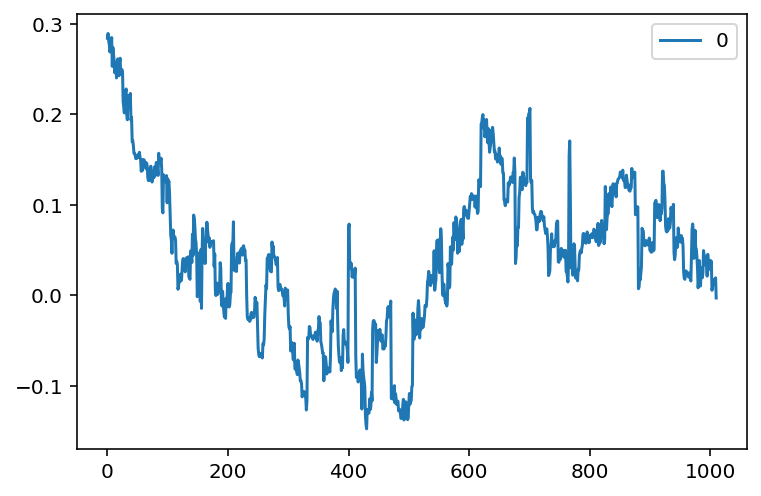

In [67]:
pd.DataFrame(lgb_pred).plot()

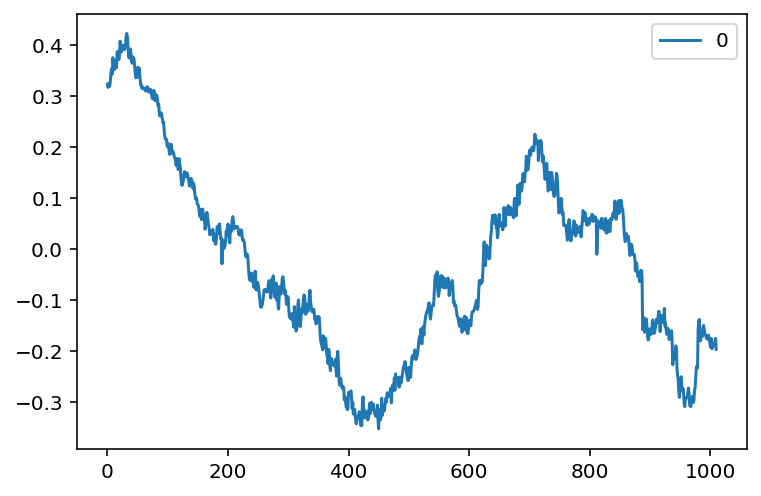

In [69]:
pd.DataFrame(y_pred).plot()

In [69]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     